In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CMv2
import calculation.SusceptibilitySimpv2 as Susceptv2

import settings.Constants as const

In [2]:

saddlePointFile = "h5_output_data/results.h5"
saddlePointFileTvalue = "h5_output_data/resultsT.h5"


In [3]:
def computeGridLines(lim1=1, num_lines1=3, lim2=3, num_lines2=3):
    
    dense_near_zero = np.linspace(0, lim1, num_lines1)
    sparse_far = np.linspace(lim1, lim2, num_lines2)
    
    grid_lines_pos = np.concatenate([dense_near_zero, sparse_far])
    grid_lines_neg = -grid_lines_pos[::-1] 
    
    grid_lines = np.unique(np.concatenate([grid_lines_neg, grid_lines_pos]))
    
    for x_line in grid_lines:
        plt.axvline(x=x_line, color='#b0b0b0', linewidth=0.8, alpha=0.7)

    plt.xticks(grid_lines[::2], [f"{x:.2f}" for x in grid_lines[::2]])
    plt.grid(True, axis='y')


In [4]:


with h5py.File(saddlePointFile, 'r') as f:
    saddle_points = f['SaddlePoint/saddle_points'][:]
    couplingValue = f['SaddlePoint/coupling'][()]
    Tvalue = f['SaddlePoint/T'][()]
    voltageSpacePlot = f['SaddlePoint/voltageSpacePlot'][:]
    lambdaSpacePlot = f['SaddlePoint/lambdaSpacePlot'][:]
    
    phi_voltage = f['SaddlePoint/phi-Voltage'][:]
    phi_lambda = f['SaddlePoint/phi-Lambda'][:]
    
    lambdaSamples = f['SaddlePoint/lambdaSamples'][:]
    voltageSamples = f['SaddlePoint/voltageSamples'][:]
    
    colorsVoltage = f['SaddlePoint/colorsVoltage'][:]
    colorsLambda = f['SaddlePoint/colorsLambda'][:]

f.close()

phiSamples = saddle_points[:,1]


In [5]:
print(phiSamples)
print(voltageSamples)
print(lambdaSamples)

[6.24032649e-01 4.25674888e-01 2.63915112e-02 6.87187332e-09]
[0.        1.0782277 1.4282277 1.7782277]
[0.6 1. ]


In [6]:
lambdaUpper = lambdaSamples[-1]
lambdaLower = lambdaSamples[0]

voltageZero = voltageSamples[0]
voltageLower = voltageSamples[1]
voltageCritical = voltageSamples[2]
voltageUpper = voltageSamples[-1]

phiZero = phiSamples[0]
phiLower = phiSamples[1]
phiCritical = phiSamples[2]
phiUpper = phiSamples[-1]

phi_voltage_func = scipy.interpolate.interp1d(voltageSpacePlot, phi_voltage[1, :], kind='linear')



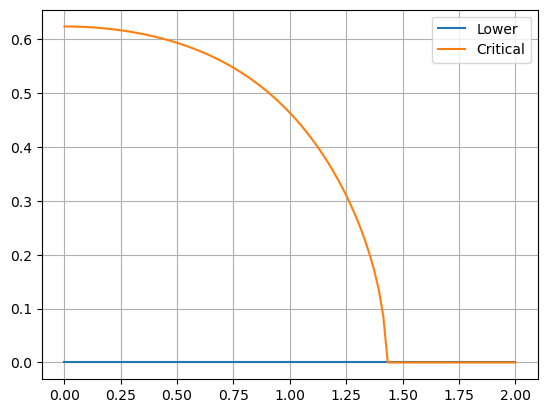

In [7]:

plt.plot(voltageSpacePlot, phi_voltage[0,:], label='Lower')
plt.plot(voltageSpacePlot, phi_voltage[1,:], label='Critical')
plt.legend()
plt.grid()

In [8]:
def computeDKfunc(lambdaValue, PiKdata, PiRdata):
    den = (-2.0*lambdaValue + np.real(PiRdata))**2 + np.imag(PiRdata)**2
    
    if den.size > 1:
        mask = np.abs(den) < 1e-7
        den[mask] = 1e-5
    
    DKdata = -PiKdata/den
    return DKdata


# def computeXK(PiKdata, PiRdata, lambdaValue):
#     den = 1.0 - PiRdata/(2.0*lambdaValue)
#     denReal = np.real(den)
#     denImag = np.imag(den)
#     return -PiKdata*np.reciprocal(denReal**2 + denImag**2)/(2.0*lambdaValue**2)



# def computeXR(PiRdata, lambdaValue):
#     den = 1.0 - PiRdata/(2.0*lambdaValue)
#     return -PiRdata*np.reciprocal(den)/(2.0*lambdaValue**2)


def computeXK(PiKdata, PiRdata, lambdaValue):
    den = 1.0 - PiRdata/(2.0*lambdaValue)
    denReal = np.real(den)
    denImag = np.imag(den)
    return -PiKdata*np.reciprocal(denReal**2 + denImag**2)



def computeXR(PiRdata, lambdaValue):
    den = 1.0 - PiRdata/(2.0*lambdaValue)
    return -PiRdata*np.reciprocal(den)


def computeRatioFD(PiR, PiK, omegaSpace):
    omegaMin = np.abs(omegaSpace).min()
    ratioFD = np.imag(PiK)/np.imag(PiR)
    ratioFD = np.where(np.abs(omegaSpace) <= omegaMin, np.nan, ratioFD)
    return ratioFD


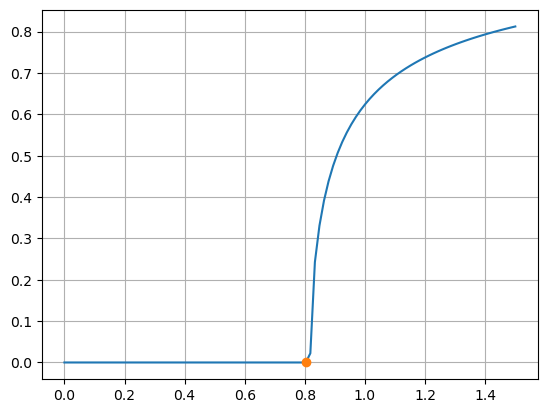

In [9]:

### Zero Voltage

lambdaCriticalZeroVoltage = 0.0 
phiCriticalZeroVoltage = 0.0

for i in range(len(lambdaSpacePlot)):
    if np.abs(phi_lambda[0,i]) > 1e-3:
        lambdaCriticalZeroVoltage = lambdaSpacePlot[i-1]
        phiCriticalZeroVoltage = phi_lambda[0,i-1]
        break

plt.plot(lambdaSpacePlot, phi_lambda[0,:], label='Lower')
plt.plot(lambdaCriticalZeroVoltage, phiCriticalZeroVoltage, 'o', label='Critical')
plt.grid()

In [10]:


omegaSpaceCenter = np.linspace(1e-8, 2e-3, 100)
omegaSpaceRight = np.linspace(0.5e-3, 1e-1, 200)
omegaSpaceRight2 = np.linspace(1e-1, 3.0, 200)
omegaSpace = np.unique(np.concatenate((omegaSpaceCenter, omegaSpaceRight, omegaSpaceRight2)))

# lambdaCriticalZeroVoltage = lambdaCriticalZeroVoltage - 0.1


PiRZeroVoltageOmega = Susceptv2.computePiR(omegaSpace, lambdaCriticalZeroVoltage, phiCriticalZeroVoltage, 0.0, couplingValue, Tvalue=Tvalue)

DRZeroVoltageOmega = np.reciprocal(-2.0*lambdaCriticalZeroVoltage + PiRZeroVoltageOmega)

PiKZeroVoltageOmega = Susceptv2.computePiK(omegaSpace, lambdaCriticalZeroVoltage, phiCriticalZeroVoltage, 0.0, couplingValue, Tvalue=Tvalue)

# PiKZeroVoltageOmegaNum = Susceptv2.computePiKNum(omegaSpace, lambdaCriticalZeroVoltage, phiCriticalZeroVoltage, 0.0, couplingValue, TValue=Tvalue)


DKZeroVoltageOmega = computeDKfunc(lambdaCriticalZeroVoltage, PiKZeroVoltageOmega, PiRZeroVoltageOmega)

XRZeroVoltageOmega = computeXR(PiRZeroVoltageOmega, lambdaCriticalZeroVoltage)

XKZeroVoltageOmega = computeXK(PiKZeroVoltageOmega, PiRZeroVoltageOmega, lambdaCriticalZeroVoltage)



/Users/joseafonso/Desktop/QP_paper/calculation/SusceptibilitySimpv2.py:72: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateEpsilonReal = lambda omega: scipy.integrate.quad(PiAtotReal, -const.epsilonDOS, const.epsilonDOS, args=(MFv2.DOS1func, omega), limit=140)[0]


1.428227703343414 1.928227703343414


  0%|          | 0/75 [00:00<?, ?it/s]/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_5599/3769564817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PiRZeroOmegaV[i] = Susceptv2.computePiR(np.array([1e-7]), lambdaUpper, phiValue, voltageCheck[i], couplingValue, Tvalue=Tvalue)
/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_5599/3769564817.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PiKZeroOmegaV[i] = Susceptv2.computePiK(np.array([1e-7]), lambdaUpper, phiValue, voltageCheck[i], couplingValue, Tvalue=Tvalue)
100%|██████████| 75/75 [00:01<00:00, 63.22it/s]
/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T


XK: Slope: -2.0134322771662094, Intercept: 2.761598512240866
XR Slope: -1.0968439345627952, Intercept: 1.488098839649587


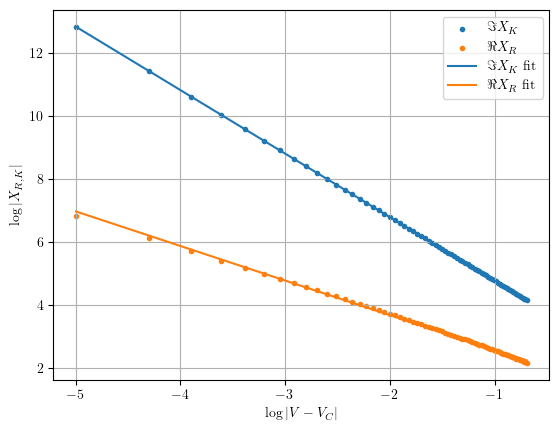

In [11]:
### Zero Frequency Susceptibility as function of the voltage
epsilon = 5e-1
voltageCheck = np.linspace(voltageCritical, voltageCritical+epsilon, 75)


print(min(voltageCheck), max(voltageCheck))

PiRZeroOmegaV = np.zeros(len(voltageCheck), dtype=complex)
PiKZeroOmegaV = np.zeros(len(voltageCheck), dtype=complex)

pbar = tqdm(total=len(voltageCheck))

for i in range(len(voltageCheck)):
    phiValue = phi_voltage_func(voltageCheck[i])
    PiRZeroOmegaV[i] = Susceptv2.computePiR(np.array([1e-7]), lambdaUpper, phiValue, voltageCheck[i], couplingValue, Tvalue=Tvalue)
    PiKZeroOmegaV[i] = Susceptv2.computePiK(np.array([1e-7]), lambdaUpper, phiValue, voltageCheck[i], couplingValue, Tvalue=Tvalue)
    
    pbar.update(1)

pbar.close()

XRZeroOmegaV = computeXR(PiRZeroOmegaV, lambdaUpper)
XKZeroOmegaV = computeXK(PiKZeroOmegaV, PiRZeroOmegaV, lambdaUpper)

logXRZeroOmegaVReal = np.log(np.abs(np.real(XRZeroOmegaV)))
logXKZeroOmegaVImag = np.log(np.abs(np.imag(XKZeroOmegaV)))
logAbsVoltage = np.log(np.abs(voltageCheck-voltageCritical))


print()

slopeK, interceptK, r_valueK, p_valueK, std_errK = scipy.stats.linregress(logAbsVoltage[1:-1], logXKZeroOmegaVImag[1:-1])
print(f"XK: Slope: {slopeK}, Intercept: {interceptK}")


slopeR, interceptR, r_valueR, p_valueR, std_errR = scipy.stats.linregress(logAbsVoltage[1:-1], logXRZeroOmegaVReal[1:-1])
print(f"XR Slope: {slopeR}, Intercept: {interceptR}")


plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.scatter(logAbsVoltage, logXKZeroOmegaVImag, label=r'$\Im X_K$', marker='.')
plt.scatter(logAbsVoltage, logXRZeroOmegaVReal, label=r'$\Re X_R$', marker='.')

plt.plot(logAbsVoltage, slopeK*logAbsVoltage + interceptK, label=r'$\Im X_K$ fit')
plt.plot(logAbsVoltage, slopeR*logAbsVoltage + interceptR, label=r'$\Re X_R$ fit')

plt.xlabel(r'$\log|V-V_C|$')
plt.ylabel(r'$\log|X_{R,K}|$')
plt.legend()
plt.grid()



Slope: -1.9718586821015482, Intercept: 0.6094088465731673


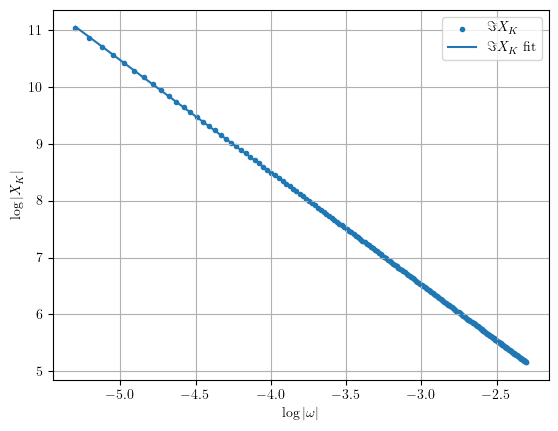

In [24]:

### Susceptibility as function of the frequency

omegaSpace = np.linspace(5e-3, 1e-1, 200)

phiValue = phiCritical
PiRCriticalOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)
PiKCriticalOmega = Susceptv2.computePiK(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)

XKCriticalOmega = computeXK(PiKCriticalOmega, PiRCriticalOmega, lambdaUpper)

logXKCriticalOmegaImag = np.log(np.abs(np.imag(XKCriticalOmega)))
logAbsVoltage = np.log(np.abs(omegaSpace))


print()

slopeK, interceptK, r_valueK, p_valueK, std_errK = scipy.stats.linregress(logAbsVoltage[1:-1], logXKCriticalOmegaImag[1:-1])
print(f"Slope: {slopeK}, Intercept: {interceptK}")



plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.scatter(logAbsVoltage, logXKCriticalOmegaImag, label=r'$\Im X_K$', marker='.')

plt.plot(logAbsVoltage, slopeK*logAbsVoltage + interceptK, label=r'$\Im X_K$ fit')

plt.xlabel(r'$\log|\omega|$')
plt.ylabel(r'$\log|X_{K}|$')
plt.legend()
plt.grid()


In [94]:

voltageValue = 0.8
# phi_volt = phi_voltage_func(voltageValue)
lambda_zero = 1.0

def XR_check(omega, voltageValue):
    phi_volt = phi_voltage_func(voltageValue)
    omegaSpace = np.array([omega])
    PiR = Susceptv2.computePiR(omegaSpace, lambda_zero, phi_volt, voltageValue , couplingValue, Tvalue=Tvalue)
    XR = computeXR(PiR, lambda_zero)
    return XR[0]

def XR_check_imag(omega, voltageValue):
    phi_volt = phi_voltage_func(voltageValue)
    omegaSpace = np.array([omega])
    PiR = Susceptv2.computePiR(omegaSpace, lambda_zero, phi_volt, voltageValue, couplingValue, Tvalue=Tvalue)
    XR = computeXR(PiR, lambda_zero)
    return XR[0].imag


from scipy.integrate import quad

def kramers_kronig_transform(omega, imag_func, *args):
    # The integrand for the principal value integral.
    # Note: The 1/(w' - w) part is handled by scipy's 'weight' parameter.
    integrand = lambda omega_prime: imag_func(omega_prime, *args)
    
    real_part, _ = quad(
        integrand, -100, 100, weight='cauchy', wvar=omega
    )
    
    return real_part / np.pi


In [95]:
omega_vals = np.linspace(-1.5, 1.5, 10)

voltageValue = 0.0
kramer_vec = []
true_vec = []

voltageValue1 = 0.5
kramer_vec1 = []
true_vec1 = []

voltageValue2 = 1.0
kramer_vec2 = []
true_vec2 = []


for omega in omega_vals:
    result = kramers_kronig_transform(omega, lambda omega: XR_check_imag(omega, voltageValue=voltageValue))
    result_true = XR_check(omega, voltageValue=voltageValue)
    kramer_vec.append(result)
    true_vec.append(result_true)
    
    result = kramers_kronig_transform(omega, lambda omega: XR_check_imag(omega, voltageValue=voltageValue1))
    result_true = XR_check(omega, voltageValue=voltageValue1)
    kramer_vec1.append(result)
    true_vec1.append(result_true)
    
    result = kramers_kronig_transform(omega, lambda omega: XR_check_imag(omega, voltageValue=voltageValue2))
    result_true = XR_check(omega, voltageValue=voltageValue2)
    kramer_vec2.append(result)
    true_vec2.append(result_true)
    

    print("omega: ", omega)

omega:  -1.5
omega:  -1.1666666666666667
omega:  -0.8333333333333334
omega:  -0.5
omega:  -0.16666666666666674
omega:  0.16666666666666652
omega:  0.5
omega:  0.833333333333333
omega:  1.1666666666666665
omega:  1.5


In [96]:
kramer_vec_arr = np.array(kramer_vec)
true_vec_arr = np.array(true_vec)
kramer_vec1_arr = np.array(kramer_vec1)
true_vec1_arr = np.array(true_vec1)
kramer_vec2_arr = np.array(kramer_vec2)
true_vec2_arr = np.array(true_vec2)

In [98]:
print(kramer_vec_arr)
print(true_vec_arr.real)

[-0.11862985 -0.35542865 -0.81509447 -1.67917542 -2.70321097 -2.70321097
 -1.67917542 -0.81509447 -0.35542865 -0.11862985]
[-0.11881232 -0.3556111  -0.81527692 -1.67935787 -2.70339342 -2.70339342
 -1.67935787 -0.81527692 -0.3556111  -0.11881232]


In [99]:
print(kramer_vec1_arr)
print(true_vec1_arr.real)

[-0.05364286 -0.25865933 -0.67696059 -1.60781364 -3.29104579 -3.29104579
 -1.60781364 -0.67696059 -0.25865933 -0.05364286]
[-0.05382536 -0.25884183 -0.67714307 -1.60799612 -3.29122827 -3.29122827
 -1.60799612 -0.67714307 -0.25884183 -0.05382536]


In [100]:
print(kramer_vec2_arr)
print(true_vec2_arr.real)

[ 0.14287188  0.04057383 -0.21477927 -1.04801167 -5.21167783 -5.21167783
 -1.04801167 -0.21477927  0.04057383  0.14287188]
[ 0.14268927  0.04039122 -0.21496187 -1.04819427 -5.21186043 -5.21186043
 -1.04819427 -0.21496187  0.04039122  0.14268927]


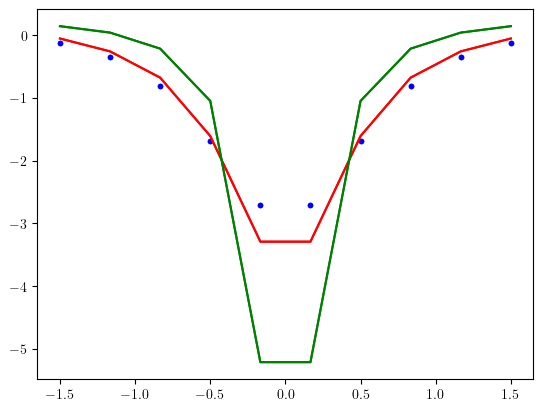

In [103]:
plt.plot(omega_vals, kramer_vec, '.', color="blue")
plt.plot(omega_vals, true_vec_arr.real, '.', color="blue")

plt.plot(omega_vals, kramer_vec1, color="red")
plt.plot(omega_vals, true_vec1_arr.real, color="red")

plt.plot(omega_vals, kramer_vec2, color="green")
plt.plot(omega_vals, true_vec2_arr.real , color="green")

In [130]:
print(phi_voltage_func(voltageCritical))
print(voltageCritical)

0.026391511223022024
1.428227703343414


In [151]:

### Susceptibility as function of the frequency

omegaSpace = np.linspace(1e-5, 1e-1, 300)

phiValue = phiCritical
# PiRCriticalOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)
PiRCriticalOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)
PiKCriticalOmega = Susceptv2.computePiK(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)

XRCriticalOmega = computeXR(PiRCriticalOmega, lambdaUpper)
# logXRCriticalOmegaReal = np.log(np.abs(np.real(XRCriticalOmega)))
# logAbsVoltage = np.log(np.abs(omegaSpace))

# logXRCriticalOmegaReal = np.abs(np.imag(XRCriticalOmega))
# logAbsVoltage = np.log(np.abs(omegaSpace))
logAbsVoltage = np.abs(omegaSpace)

# slopeR, interceptR, r_valueR, p_valueR, std_errR = scipy.stats.linregress(logAbsVoltage[1:-1], logXRCriticalOmegaReal[1:-1])
# print(f"Slope: {slopeR}, Intercept: {interceptR}")


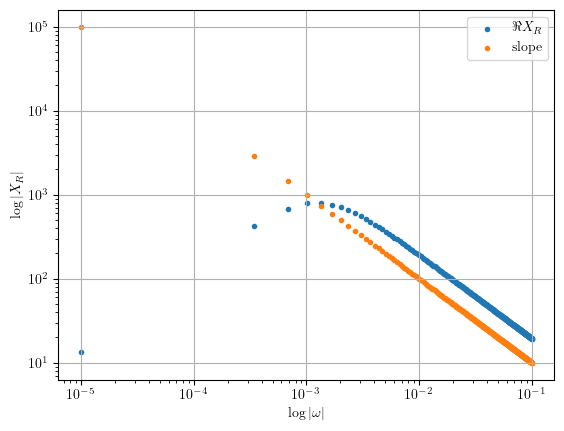

In [152]:

plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
# plt.scatter(logAbsVoltage, logXRCriticalOmegaReal, label=r'$\Re X_R$', marker='.')
plt.scatter(logAbsVoltage, np.abs(XRCriticalOmega.imag), label=r'$\Re X_R$', marker='.')
plt.scatter(logAbsVoltage, 1/logAbsVoltage, label=r'slope', marker='.')
# plt.plot(logAbsVoltage, slopeR*logAbsVoltage + interceptR, label=r'$\Re X_R$ fit')

plt.xlabel(r'$\log|\omega|$')
plt.ylabel(r'$\log|X_{R}|$')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid()